# Model training on AzureML from same locally run notebook

At the end of this notebook, we will have learned how to:
- Create an AMLcompute target
- Trigger the execution of a notebook on AzureML.

We will leverage the 3_Model_training_from_local_machine_to_AzureML.ipynb notebook and the notebook_launcher.py code (both available in this << PUT LINK HERE >> repository). Ultimately we will train a model remotely using the notebook we used to train locally.

## Pre-requisites
It is assumed here that our local environment and Azure subscription are already set up (cf. [details](LINK TO PRIOR notebook)).

## Library import

In [184]:
# For automatic reloading of modified libraries
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Regular python libraries
import matplotlib.pyplot as plt
import os
from sys import platform


# fast.ai
from fastai.vision import *
import torchvision.models as models

# Azure
import azureml.core
from azureml.core import Workspace, Experiment
from azureml.core.conda_dependencies import CondaDependencies 
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.core.runconfig import RunConfiguration
from azureml.core.runconfig import DEFAULT_GPU_IMAGE
from azureml.core.script_run_config import ScriptRunConfig
from azureml.widgets import RunDetails

## Azure

### Workspace
Let's start by loading the working space which information we saved in our aml_config/config.json file

In [2]:
ws = Workspace.from_config()

Found the config file in: C:\Users\alteste\Repos\ComputerVisionBestPractices\image_classification\notebooks\deployment\aml_config\config.json


Let's check that the workspace is properly loaded

In [223]:
# Print the workspace attributes
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

### Experiment

As we will be running computations on a remote cluster, we need to create an experiment or used one we already have.

In [29]:
# Create a new experiment
experiment_name = 'imgclassif-remote-training'
experiment = Experiment(workspace=ws, name=experiment_name)

In [30]:
print("New experiment:\n --> Name: {}\n --> Workspace name: {}".format(experiment.name, experiment.workspace.name))

New experiment:
 --> Name: imgclassif-remote-training
 --> Workspace name: ws2_tutorials2


### Compute resources

We also need to create or retrieve the proper compute resources. Here, we will use an [AMLCompute target](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-set-up-training-targets) composed of [GPU nodes](https://docs.microsoft.com/en-us/azure/virtual-machines/linux/sizes-gpu).

In [171]:
cluster_name = "gpuclusternc6"

try:
    gpu_cluster = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    
    # We are creating here a AMLcompute cluster that leverages GPUs
    # To use CPUs, we should replace "Standard_NC6" by "Standard_D3_v2"
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NC6', max_nodes=1)
    # Standard_NC6 machines have only 1 GPU
    
    # We actually create the cluster here
    gpu_cluster = ComputeTarget.create(ws, cluster_name, compute_config)

    # We can also impose a minimum number of nodes and a specific timeout. 
    # If no min_node_count is provided, it uses the scale settings for the cluster
    gpu_cluster.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

# We use get_status() to get a detailed status for the current cluster
print(gpu_cluster.get_status().serialize())

Creating a new compute target...
Creating
Succeeded
AmlCompute wait for completion finished
Minimum number of nodes requested have been provisioned
{'allocationState': 'Steady', 'allocationStateTransitionTime': '2019-03-02T17:25:03.504000+00:00', 'creationTime': '2019-03-02T17:24:45.063481+00:00', 'currentNodeCount': 0, 'errors': None, 'modifiedTime': '2019-03-02T17:25:04.100338+00:00', 'nodeStateCounts': {'idleNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0, 'preparingNodeCount': 0, 'runningNodeCount': 0, 'unusableNodeCount': 0}, 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 2, 'nodeIdleTimeBeforeScaleDown': 'PT120S'}, 'targetNodeCount': 0, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_NC12'}


We could also use a "Standard NC12" machine, which has 2 GPUs, and allow for the cluster to scale up to 2 nodes. However, the training of the current model does not require as much power. We are then using only a Standard NC6 machine.

### Run configuration

Now that everything is in place, let's create a new run and configure it, so it runs with the libraries we need.

In [172]:
current_directory = os.getcwd()
default_conda_environment = 'myenv2.yml'  # contains import of the papermill library

conda_env = os.path.join(current_directory, default_conda_environment)

# Create a new runconfig object
run_configuration = RunConfiguration()

# Use the GPU cluster we created above
run_configuration.target = cluster_name

# Enable Docker
run_configuration.environment.docker.enabled = True

# Set Docker base image to the default GPU-based image
run_configuration.environment.docker.base_image = DEFAULT_GPU_IMAGE

# Use our myenv.yml file to create a conda environment in the Docker image for execution
# Here, user_managed_dependencies is False because the Docker image does not have the libraries installed yet
run_configuration.environment.python.user_managed_dependencies = False

# Auto-prepare the Docker image when used for execution (if it is not already prepared)
run_configuration.auto_prepare_environment = True

# Specify CondaDependencies object, add necessary packages
# Here, we use our myenv.yml file, as i contains all the packages we need
run_configuration.environment.python.conda_dependencies = CondaDependencies(conda_dependencies_file_path=conda_env)

In [222]:
script_run_config = ScriptRunConfig(source_directory='./from_local_to_remote/',
                                    script='notebook_launcher.py', 
                                    arguments=['--notebook_path', 
                                               '3_Model_training_from_local_machine_to_AzureML.ipynb'],
                                    run_config=run_configuration)

### Run execution

In [174]:
run = experiment.submit(script_run_config)

From here, we can track and visualize the progress of training.

In [175]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
imgclassif-remote-training,imgclassif-remote-training_1551547535_1f977765,azureml.scriptrun,Queued,Link to Azure Portal,Link to Documentation


### Progress and results visualization

In [176]:
print(run.get_portal_url())
run.wait_for_completion(show_output=True)

https://mlworkspace.azure.ai/portal/subscriptions/b8c23406-f9b5-4ccb-8a65-a8cb5dcd6a5a/resourceGroups/alteste-rg/providers/Microsoft.MachineLearningServices/workspaces/ws2_tutorials2/experiments/imgclassif-remote-training/runs/imgclassif-remote-training_1551547535_1f977765
RunId: imgclassif-remote-training_1551547535_1f977765

Streaming azureml-logs/60_control_log.txt

Streaming log file azureml-logs/60_control_log.txt
Streaming log file azureml-logs/80_driver_log.txt

Streaming azureml-logs/80_driver_log.txt

Installed kernelspec ipyazureml in /root/.local/share/jupyter/kernels/ipyazureml
We are running on a linux OS.
1. Parsing the arguments - 2019-03-02 17:32:16.791951
3_Model_training_from_local_machine_to_AzureML.ipynb {}
2. Executing the notebook - 2019-03-02 17:32:16.792894
Input Notebook:  3_Model_training_from_local_machine_to_AzureML.ipynb
Output Notebook: outputs/output.ipynb

100%|██████████| 28/28 [35:29<00:00, 18.64s/it]
3. Retrieving the output - 2019-03-02 18:07:48.0478

{'runId': 'imgclassif-remote-training_1551547535_1f977765',
 'target': 'gpuclusternc12',
 'status': 'Completed',
 'startTimeUtc': '2019-03-02T17:29:25.680739Z',
 'endTimeUtc': '2019-03-02T18:08:15.972745Z',
 'properties': {'azureml.runsource': 'experiment',
  'ContentSnapshotId': '32ec88fe-9e06-405f-b813-ba110d2fc1f7'},
 'runDefinition': {'Script': 'notebook_launcher.py',
  'Arguments': ['--notebook_path',
   '3_Model_training_from_local_machine_to_AzureML.ipynb'],
  'SourceDirectoryDataStore': None,
  'Framework': 0,
  'Communicator': 0,
  'Target': 'gpuclusternc12',
  'DataReferences': {},
  'JobName': None,
  'AutoPrepareEnvironment': True,
  'MaxRunDurationSeconds': None,
  'NodeCount': 1,
  'Environment': {'Python': {'InterpreterPath': 'python',
    'UserManagedDependencies': False,
    'CondaDependencies': {'name': 'project_environment',
     'dependencies': ['python=3.6.2',
      {'pip': ['azureml-defaults']},
      'scikit-learn',
      'pytorch-cpu',
      'torchvision',
     

<img src="screenshots/80_driver_log.jpg" width="500" align="right">

The `run.wait_for_completion(show_output=True)` command displays the content of the logs files that are stored on the Azure portal. These logs can be found by:
- Clicking on "Experiments"
- Selecting the name of the experiment considered here
- Clicking on the run number currently active
- Clicking on the "Logs" tab

Note: This run involves several steps:
1. Preparation of the AMLCompute target and import of all necessary libraries
2. Queuing of the job to run, i.e. resizing of the cluster from 0 to 1 node
3. Actual execution of the job

The first step can take up to 20 min. Once the preparation phase has completed, steps 2. and 3. can be run again. This is especially convenient when we want to make a change to either the notebook to be run remotely, or to the notebook_launcher.py script.

Details on the nodes status can also be seen directly in the notebook by running the `RunDetails(run).show()` command.

In [180]:
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 's…

Once the run is completed, we can retrieve the list of files that were generated:
- Log files
- Model and output notebook we stored in the "outputs/" folder.

The output notebook is the same as the original 3_Model_training_from_local_machine_to_AzureML.ipynb, but also contains the results of each cell, as executed on the AMLCompute target.

In [181]:
run.get_file_names()

['azureml-logs/55_batchai_execution.txt',
 'azureml-logs/56_batchai_stderr.txt',
 'azureml-logs/60_control_log.txt',
 'azureml-logs/80_driver_log.txt',
 'azureml-logs/azureml.log',
 'outputs/image_classif_model_cats_dogs.pkl',
 'outputs/output.ipynb']

The use of the `papermill` library, that allowed us to run the 3_Model_training_from_local_machine_to_AzureML.ipynb notebook without any changes, on the AMLCompute target, also allowed us to retrieve metrics and plot them both on the Azure portal and in this current notebook.

On the portal, these can be accessed under "Experiments", and after clicking on the experiment and then run number of interest.

<img src="screenshots/remote_training_metrics.jpg" width="800" align="left">

In this notebook, we need to retrieve the data though the `run` object.

In [219]:
print(run.get_metrics().keys())
for k in run.get_metrics().keys():
    print("{}: {} values".format(k, len(run.get_metrics()[k])))

dict_keys(['training_loss', 'accuracy', 'learning_rate', 'validation_loss'])
training_loss: 1476 values
accuracy: 4 values
learning_rate: 1476 values
validation_loss: 4 values


In [220]:
training_loss = run.get_metrics()['training_loss']
accuracy = [x for x in run.get_metrics()['accuracy']]
learning_rate = run.get_metrics()['learning_rate']
validation_loss = run.get_metrics()['validation_loss']

Text(0.5, 1.0, 'validation loss')

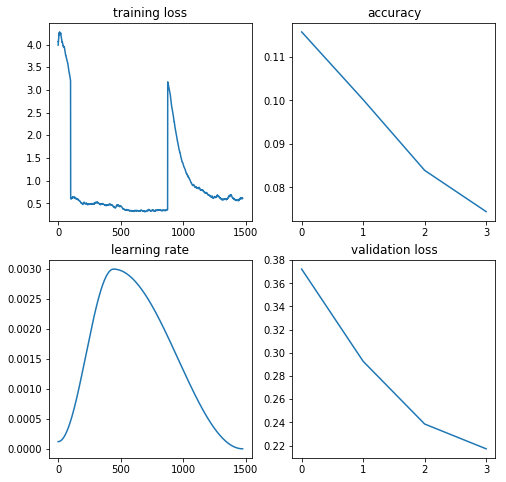

In [221]:
fig, ax = plt.subplots(2,2, figsize=(8,8))
ax[0, 0].plot(training_loss)
ax[0, 0].set_title('training loss')

ax[1, 0].plot(learning_rate)
ax[1, 0].set_title('learning rate')

ax[0, 1].plot(accuracy)
ax[0, 1].set_title('accuracy')

ax[1, 1].plot(validation_loss)
ax[1, 1].set_title('validation loss')

In [ ]:
# Run the following in the terminal first:

# jupyter nbextension uninstall --py --user azureml.widgets
# jupyter nbextension uninstall --py --user azureml.train.widgets

In [ ]:
# Reference notebook: https://github.com/Microsoft/Recommenders/blob/danielsc/azureml/notebooks/02_train_in_the_cloud/train_fastai_on_aml.ipynb
# Papermill: https://github.com/nteract/papermill